### load packages

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
%matplotlib inline
from IPython import display
from numpy.random import randn
import pandas as pd
from tensorflow.keras.layers import Dense
from tensorflow.keras import Input, Model
import seaborn as sns
import sys

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  after removing the cwd from sys.path.


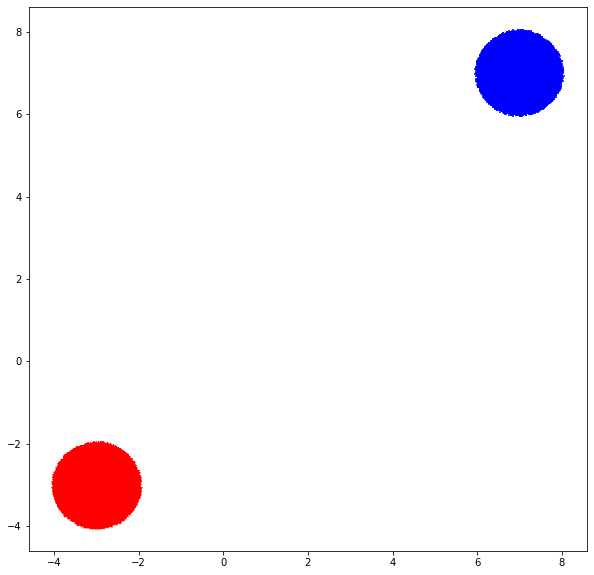

In [ ]:
n = 5000
m = 5000

t = np.random.random(size=n) * 2 * np.pi -np.pi
x1 = np.cos(t)
x2 = np.sin(t)
for i in range(n):
    len = np.sqrt(np.random.random())
    x1[i] = x1[i] * len -3
    x2[i] = x2[i] * len -3
 
s = np.random.random(size=m) * 2 * np.pi -np.pi
x3 = np.cos(s)
x4 = np.sin(s)
for j in range(m):
    len = np.sqrt(np.random.random())
    x3[j] = x3[j] * len +7
    x4[j] = x4[j] * len +7
 
 
plt.figure(figsize=(10,10))
plt.scatter(x1,x2,marker='*',color='r')
plt.scatter(x3,x4,marker='+',color='b')
plt.show()

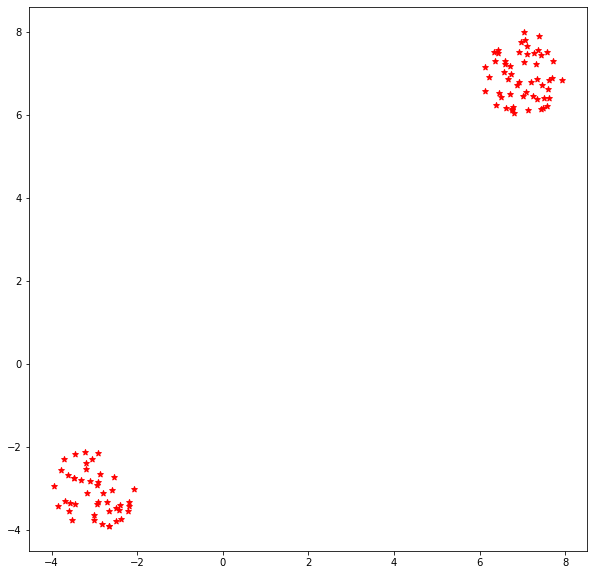

float32


In [ ]:
x_r = np.concatenate((x1,x3), axis=0)
y_r = np.concatenate((x2,x4), axis=0)

ar = np.array([x_r,y_r])
data = np.rot90(ar)

i = np.random.randint(0, 10000, 100)
x_r= data[i][:,0]
y_r= data[i][:,1]

plt.figure(figsize=(10,10))
plt.scatter(x_r, y_r, marker='*', color='r')
plt.show()
data = data.astype('float32')
print(data.dtype)

BUF = 10000
BATCH_SIZE = 128
N_BATCHES = int(BUF/BATCH_SIZE)
dataset = (
    tf.data.Dataset.from_tensor_slices(data)
    .shuffle(BUF)
    .batch(BATCH_SIZE)
)

### Define the network as tf.keras.model object

In [ ]:
class WGAN(tf.keras.Model):
    """[summary]
    I used github/LynnHo/DCGAN-LSGAN-WGAN-GP-DRAGAN-Tensorflow-2/ as a reference on this.
    
    Extends:
        tf.keras.Model
    """

    def __init__(self, **kwargs):
        super(WGAN, self).__init__()
        self.__dict__.update(kwargs)

    def generate(self, z):
        return self.gen(z)

    def discriminate(self, x):
        return self.disc(x)

    def compute_loss(self, x):
        """ passes through the network and computes loss
        """
        ### pass through network
        # generating noise from a uniform distribution

        z_samp = tf.random.normal([x.shape[0], self.latent_dim])

        # run noise through generator
        x_gen = self.generate(z_samp)
        # discriminate x and x_gen
        logits_x = self.discriminate(x)
        logits_x_gen = self.discriminate(x_gen)

        # gradient penalty
        d_regularizer = self.gradient_penalty(x, x_gen)
        ### losses
        disc_loss = (
            tf.reduce_mean(logits_x)
            - tf.reduce_mean(logits_x_gen)
            + d_regularizer * self.gradient_penalty_weight
        )

        # losses of fake with label "1"
        gen_loss = tf.reduce_mean(logits_x_gen)

        return disc_loss, gen_loss

    def compute_gradients(self, x):
        """ passes through the network and computes loss
        """
        ### pass through network
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            disc_loss, gen_loss = self.compute_loss(x)

        # compute gradients
        gen_gradients = gen_tape.gradient(gen_loss, self.gen.trainable_variables)

        disc_gradients = disc_tape.gradient(disc_loss, self.disc.trainable_variables)

        return gen_gradients, disc_gradients

    def apply_gradients(self, gen_gradients, disc_gradients):

        self.gen_optimizer.apply_gradients(
            zip(gen_gradients, self.gen.trainable_variables)
        )
        self.disc_optimizer.apply_gradients(
            zip(disc_gradients, self.disc.trainable_variables)
        )

    def gradient_penalty(self, x, x_gen):
        epsilon = tf.random.uniform([x.shape[0], 1], 0.0, 1.0)
        x_hat = epsilon * x + (1 - epsilon) * x_gen
        with tf.GradientTape() as t:
            t.watch(x_hat)
            d_hat = self.discriminate(x_hat)
        gradients = t.gradient(d_hat, x_hat)
        ddx = tf.sqrt(tf.reduce_sum(gradients ** 2, 1))
        d_regularizer = tf.reduce_mean((ddx - 1.0) ** 2)
        return d_regularizer

    @tf.function
    def train(self, train_x):
        gen_gradients, disc_gradients = self.compute_gradients(train_x)
        self.apply_gradients(gen_gradients, disc_gradients)







### Define the network architecture

In [ ]:
def define_discriminator():
    inputs = Input(shape=(2,))
    x = Dense(10, activation='relu')(inputs)
    x = Dense(20, activation='relu')(x)
    x = Dense(30, activation='relu')(x)
    x = Dense(40, activation='relu')(x)
    outputs = Dense(1, activation='linear')(x)

    model = Model(inputs,outputs)

    return model

def define_generator(latent_dim, n_outputs=2):
    inputs = Input(shape=(latent_dim,))
    x = Dense(40, activation='relu')(inputs)
    x = Dense(30, activation='relu')(x)
    x = Dense(20, activation='relu')(x)
    x = Dense(10, activation='relu')(x)
    outputs = Dense(n_outputs, activation='linear')(x)

    model = Model(inputs, outputs)
    return model

latent_dim = 50

d_model = define_discriminator()
g_model = define_generator(latent_dim)

### Create Model

In [ ]:
# optimizers
gen_optimizer = tf.keras.optimizers.Adam(0.0001, beta_1=0.5)
disc_optimizer = tf.keras.optimizers.RMSprop(0.0005)# train the model
# model
model = WGAN(
    gen = g_model,
    disc = d_model,
    gen_optimizer = gen_optimizer,
    disc_optimizer = disc_optimizer,
    latent_dim = latent_dim,
    gradient_penalty_weight = 10.0
)

### Train the model

In [ ]:
def plot_reconstruction(model, n = 100):
    ix = np.random.randint(0, 10000, n)
    x_real = data[ix]
    print(x_real.shape)
    x_input = randn(latent_dim * n)
    x_input = x_input.reshape(n, latent_dim)
    x_fake = model.generate(x_input)

    c = np.zeros(n)
    plt.figure(figsize=(5,5))
    plt.scatter(x_real[:,0], x_real[:,1], alpha=1)
    plt.scatter(x_fake[:,0], x_fake[:,1], alpha=0.6)
    plt.show()
    plt.close()

    x = np.linspace(-4, 8, 20, endpoint=False)
    score = np.zeros(shape=(20, 20))
    
    for i in range(20):
      for j in range(20):
        y = np.array([x[i], x[j]])
        y = y.reshape(1, 2)
        score[i][j] = model.discriminate(y)

    plt.figure(figsize=(6,6))
    h = plt.imshow(score, origin = 'lower')
    cb = plt.colorbar(h)
    plt.axis('off')
    plt.show()
    plt.close()

(100, 2)


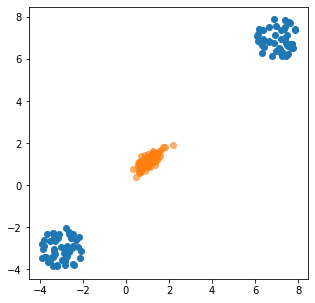

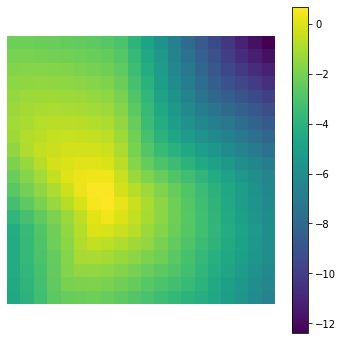

(100, 2)


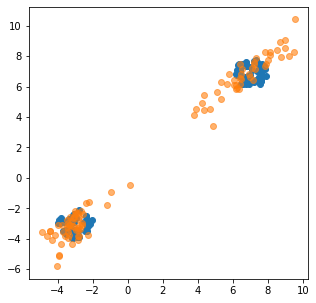

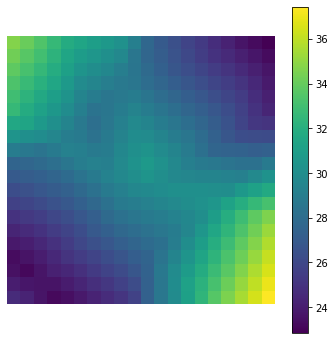

(100, 2)


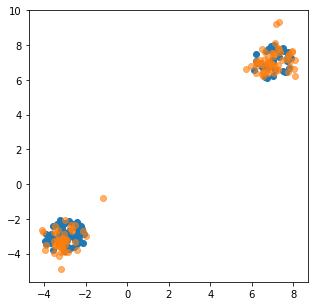

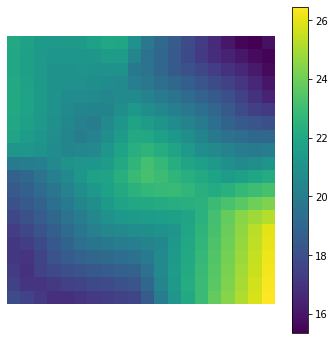

(100, 2)


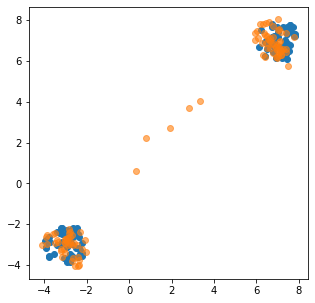

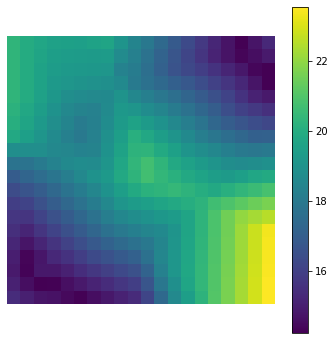

(100, 2)


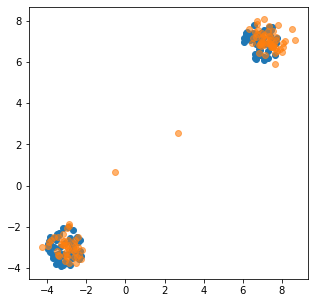

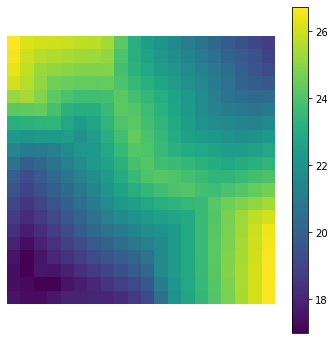

(100, 2)


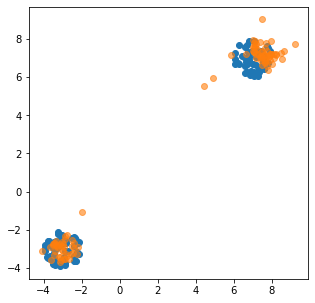

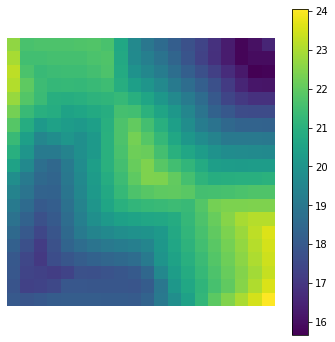

(100, 2)


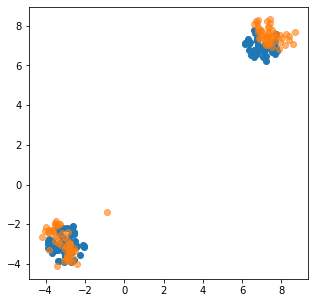

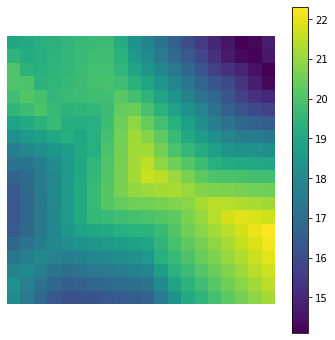

(100, 2)


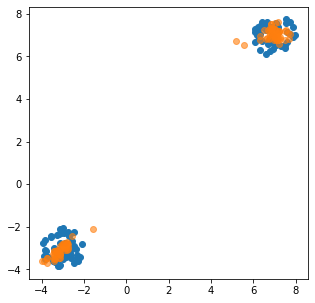

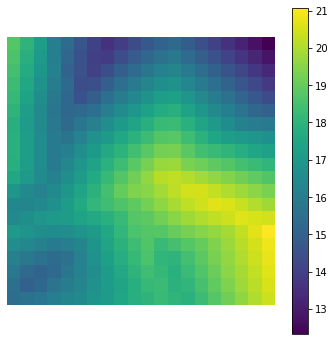

(100, 2)


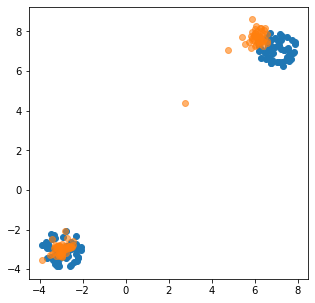

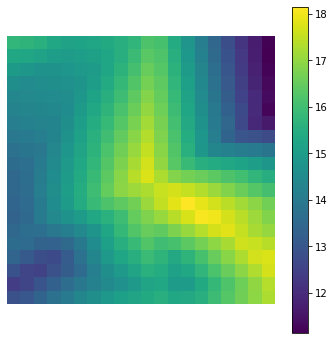

(100, 2)


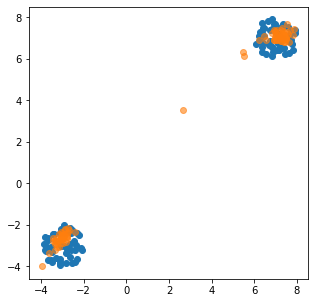

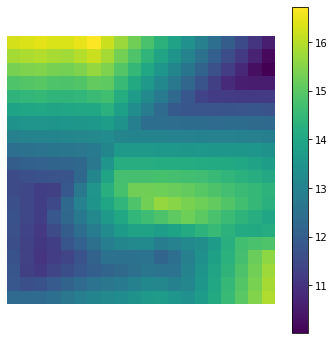

(100, 2)


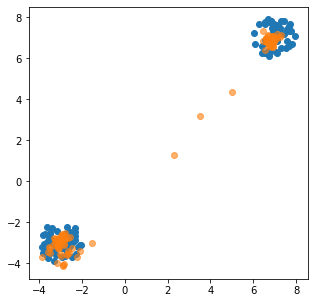

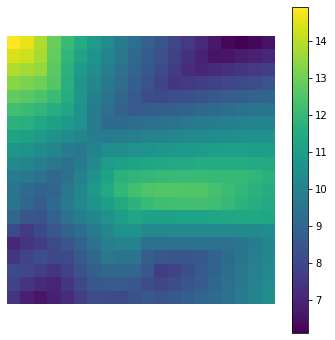

(100, 2)


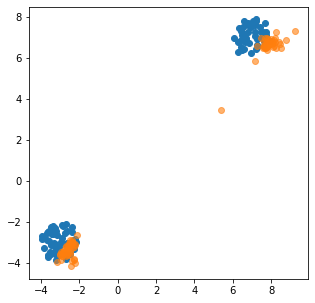

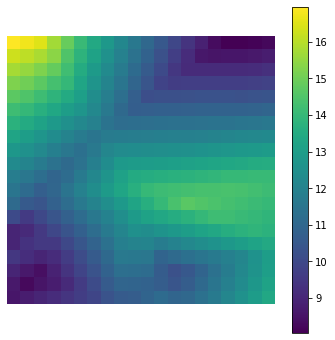

(100, 2)


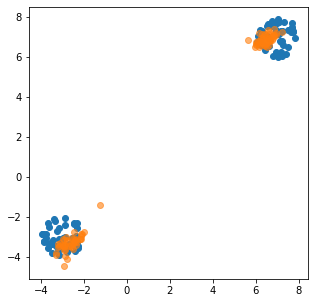

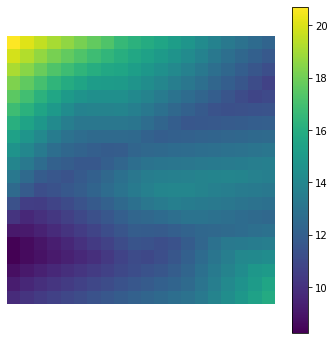

(100, 2)


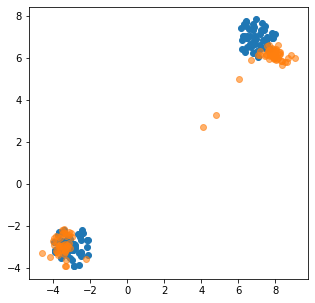

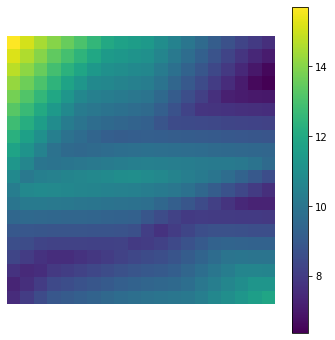

(100, 2)


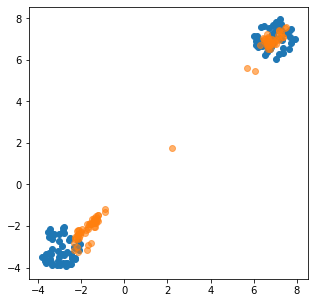

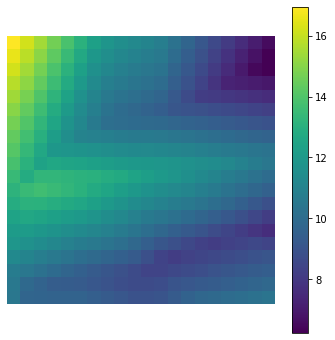

(100, 2)


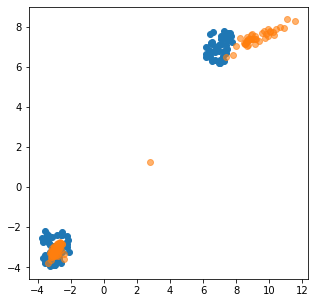

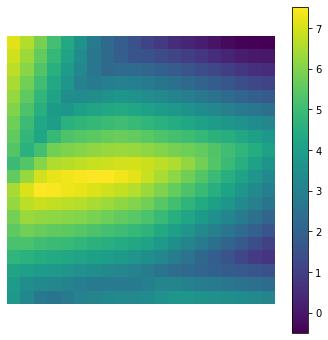

(100, 2)


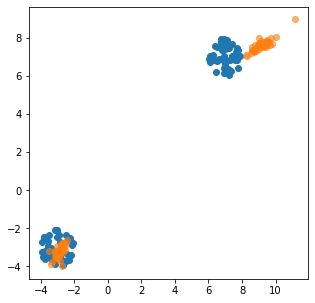

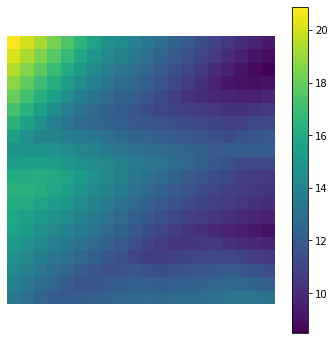

(100, 2)


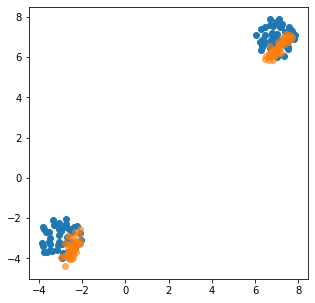

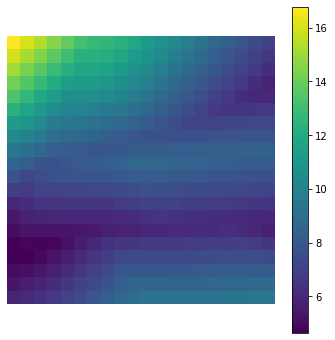

(100, 2)


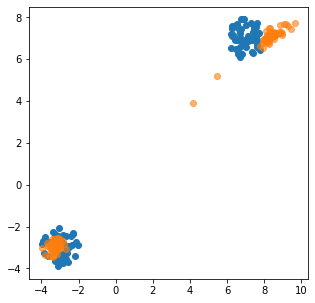

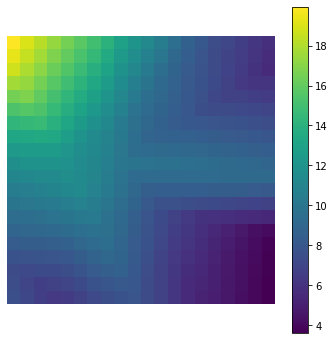

(100, 2)


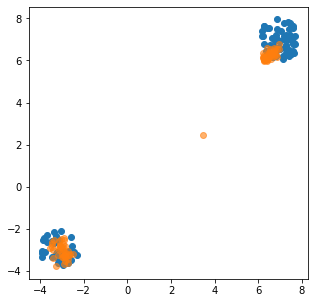

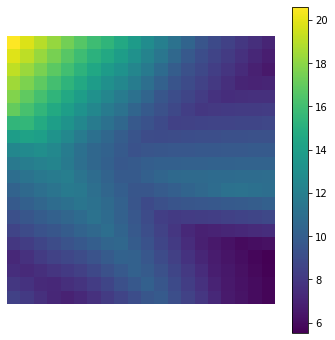

(100, 2)


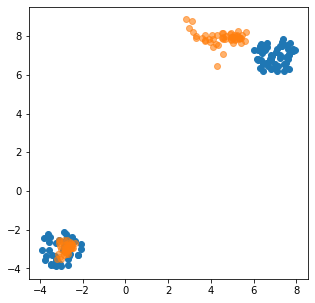

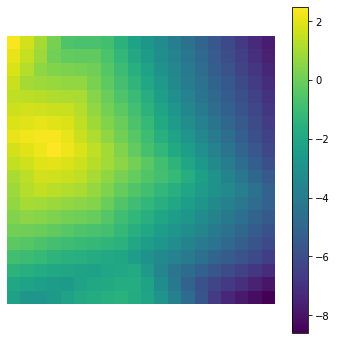

(100, 2)


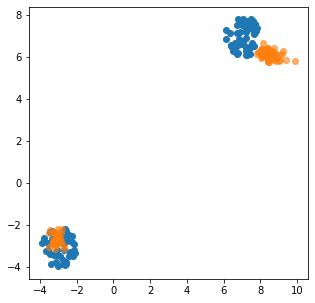

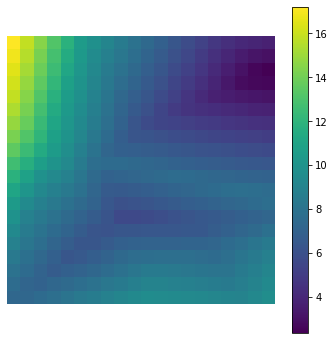

(100, 2)


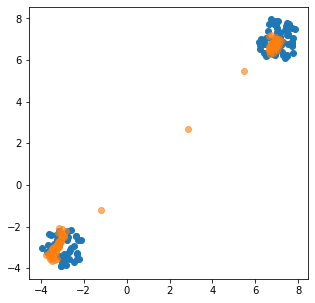

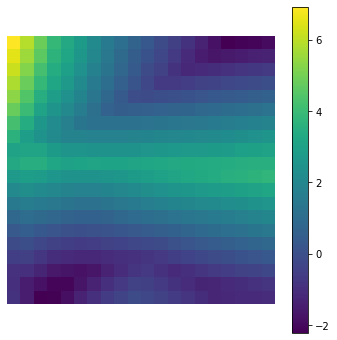

(100, 2)


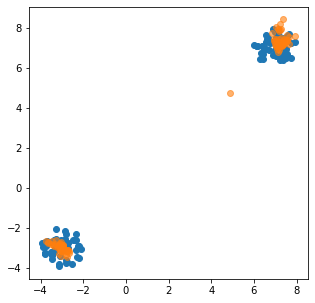

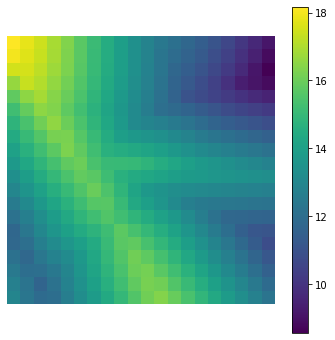

(100, 2)


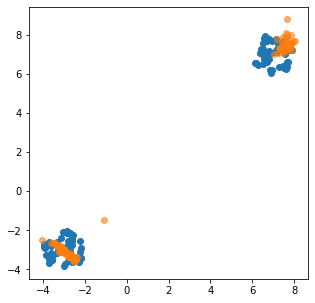

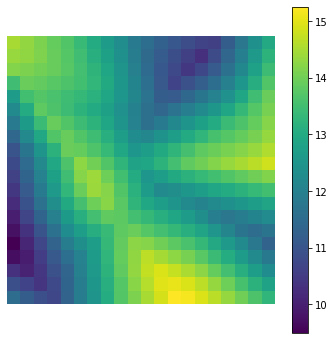

(100, 2)


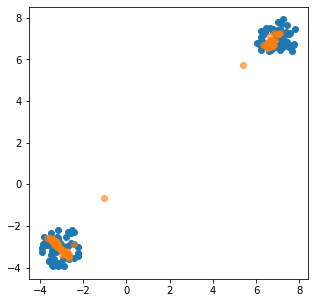

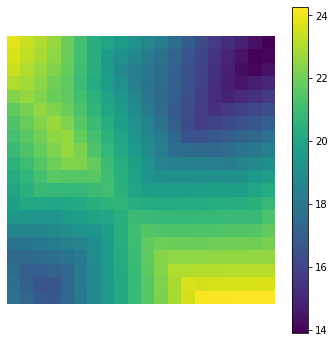

(100, 2)


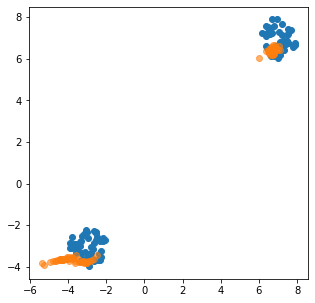

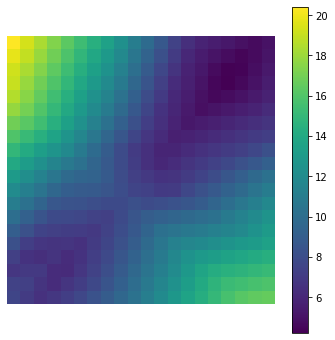

(100, 2)


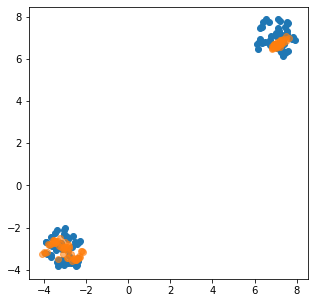

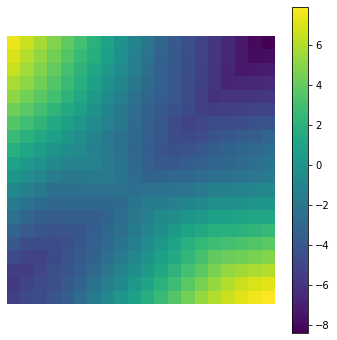

(100, 2)


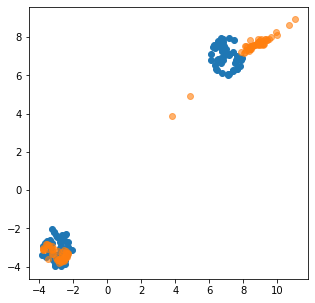

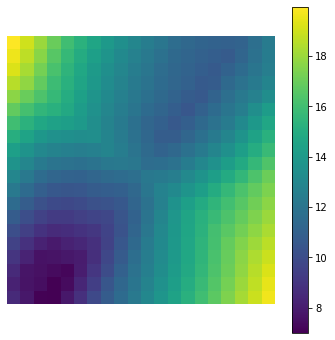

(100, 2)


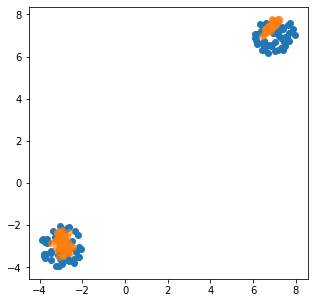

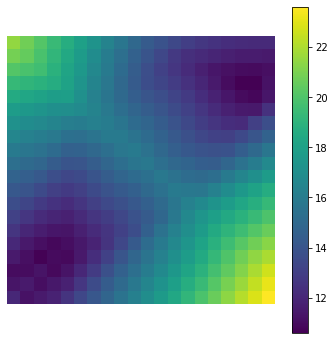

(100, 2)


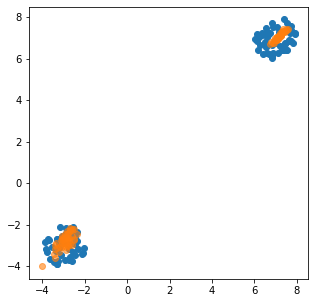

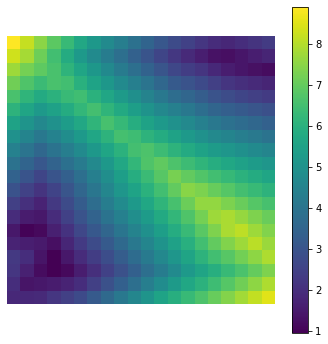

(100, 2)


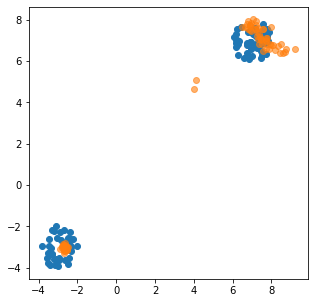

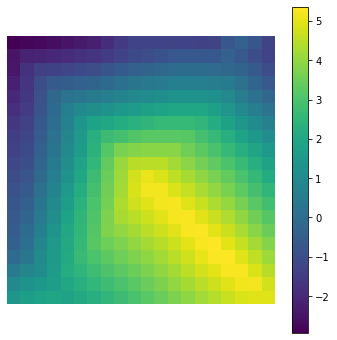

(100, 2)


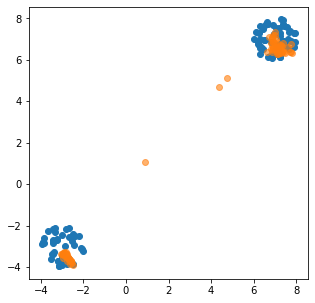

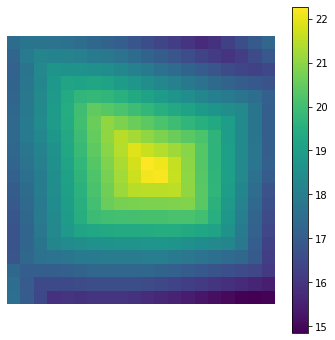

(100, 2)


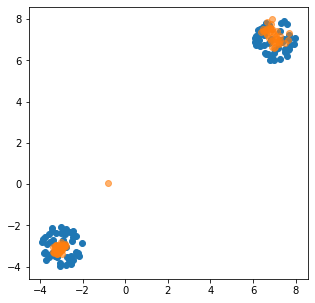

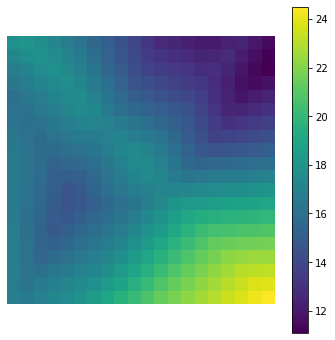

(100, 2)


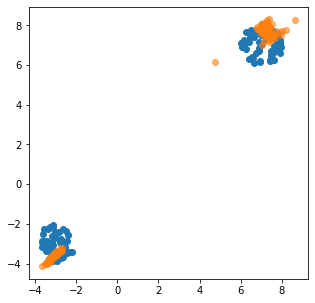

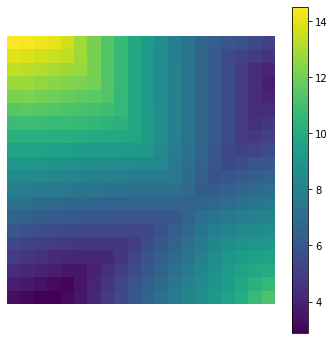

(100, 2)


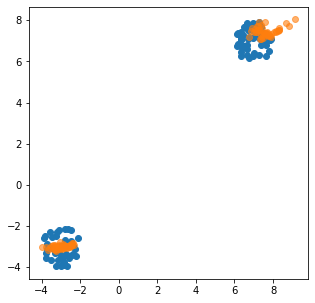

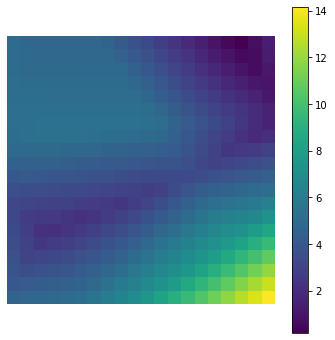

(100, 2)


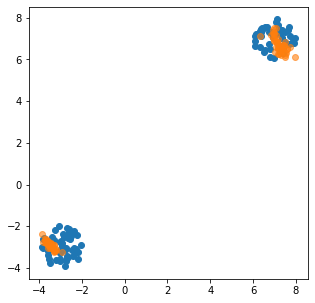

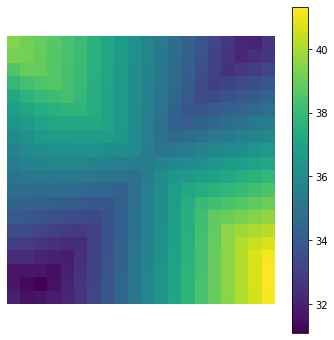

(100, 2)


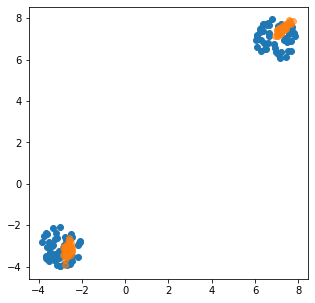

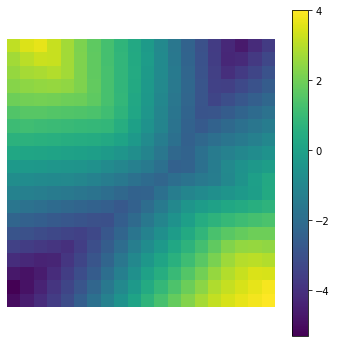

(100, 2)


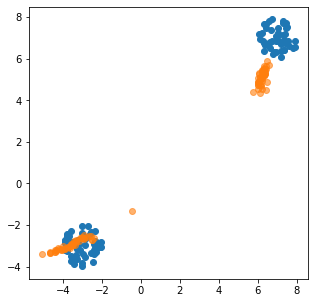

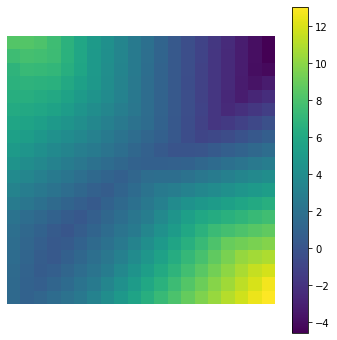

(100, 2)


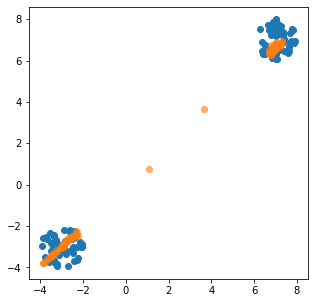

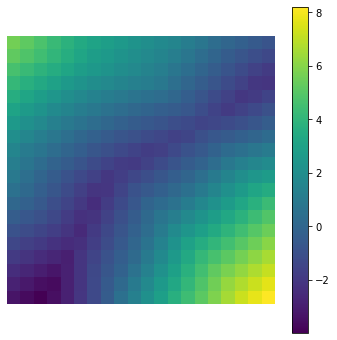

In [8]:
losses = pd.DataFrame(columns = ['disc_loss', 'gen_loss'])

n_epochs = 2000
for epoch in range(n_epochs):
    # train
    loss = []
    for train_x in dataset:
        model.train(train_x)
        loss.append(model.compute_loss(train_x))
    
    if (epoch-1) % 50 == 0:
      plot_reconstruction(model)